In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import sys

In [2]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
from torchvision import utils
show_image=True
def imshow(inp, file_name, save=False, title=None):
    """Imshow for Tensor."""
    fig = plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp, cmap='gray')
    plt.savefig(file_name)
    if show_image:
        plt.show()
    else:
        print("Don't show")

In [17]:
z_size=128
hidden_size=512
img_size=28

In [19]:
root = './data'
download = True
trans = transforms.Compose([
    transforms.Scale(img_size),
    transforms.ToTensor(),
    transforms.Normalize((
        0.5,
        0.5,
        0.5,
    ), (0.5, 0.5, 0.5))
])
train_set = dset.MNIST(
    root=root, train=True, transform=trans, download=download)
test_set = dset.MNIST(root=root, train=False, transform=trans)
batch_size = 128
kwargs = {}
train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=batch_size, shuffle=False)

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, img_size**2),
        )
    def forward(self, x):
        x = x.view(x.size()[0], z_size)
        out = self.model(x)
        out = out.view(x.size()[0], 1,img_size,img_size)
        return out

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size**2, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, 1),
        )
    def forward(self, x):
        out = self.model(x.view(x.size(0), img_size**2))
        out = out.view(out.size(0), -1)
        return torch.mean(out)

In [22]:
one = torch.FloatTensor([1])
mone = one * -1

  0%|          | 0/10000 [00:00<?, ?it/s]

show


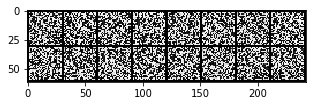

  0%|          | 10/10000 [00:57<15:59:36,  5.76s/it]

In [ ]:
from tqdm import tqdm
G = Generator()
D = Discriminator()
if torch.cuda.is_available():
    G.cuda()
    D.cuda()
G_lr = D_lr = 5e-5
optimizers = {
    'D': torch.optim.RMSprop(D.parameters(), lr=D_lr),
    'G': torch.optim.RMSprop(G.parameters(), lr=G_lr)
}
criterion = nn.BCELoss()
for epoch in tqdm(range(10000)):
    for p in D.parameters():
        p.requires_grad = True
    for _ in range(100):
        optimizers['D'].zero_grad()
        data=next(iter(train_loader))[0]
        if torch.cuda.is_available():
            data = Variable(data.cuda())
        else:
            data = Variable(data)
        output_real = D(data)
        output_real.backward(one)
        noisev = torch.randn(data.size()[0], z_size, 1, 1)
        if torch.cuda.is_available():
            noisev = Variable(noisev.cuda())
        else:
            noisev = Variable(noisev)
        fake_data = Variable(G(noisev).data)
        output_fake = D(fake_data)
        output_fake.backward(mone)
#         D_loss = -(torch.mean(output_real) - torch.mean(output_fake))

#         D_loss.backward()
        optimizers['D'].step()
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

    for p in D.parameters():
        p.requires_grad = False
    optimizers['G'].zero_grad()
    noisev = torch.randn(data.size()[0], z_size, 1, 1)
    if torch.cuda.is_available():
        noisev = Variable(noisev.cuda())
    else:
        noisev = Variable(noisev)
    fake_data = G(noisev)
    output_fake1 = D(fake_data)
    output_fake1.backward(one)
#     G_loss = -torch.mean(output_fake1)

#     G_loss.backward()
    optimizers['G'].step()

    if epoch % 1000 == 0:
        print('show')
        if torch.cuda.is_available():
            dd = utils.make_grid(fake_data.cpu().data[:16])
        else:
            dd = utils.make_grid(fake_data.data[:16])
        imshow(dd,'./results/WGAN_%d.png'%(epoch))
#         dd = utils.make_grid(data.data[:16])
#         imshow(dd,'./results/WGAN_%d.png'%(epoch))